In [2]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns 
from sklearn.preprocessing import OrdinalEncoder, MinMaxScaler, RobustScaler
from sklearn.ensemble import RandomForestClassifier
from sklearn.metrics import classification_report, confusion_matrix
from sklearn import svm
from sklearn.model_selection import GridSearchCV
from sklearn.datasets import make_classification
from sklearn.model_selection import train_test_split
from sklearn.metrics import make_scorer, f1_score, recall_score, precision_score, classification_report
from imblearn.over_sampling import SMOTE
from imblearn.over_sampling import RandomOverSampler
from sklearn.tree import export_graphviz
from sklearn.linear_model import LogisticRegression
from keras.models import Sequential
from keras.layers import Dense
import keras
from keras.callbacks import Callback,ModelCheckpoint
from keras.models import Sequential,load_model
from keras.layers import Dense, Dropout
from keras.wrappers.scikit_learn import KerasClassifier
import keras.backend as K

def db_cleaner(db,i) :
    #Elimino eventuali dati impossibili
    db = db[(db["Air temperature [K]"] > 1) | (db['Process temperature [K]'] > 1) | (db["Tool wear [min]"] > 0) | (db["Torque [Nm]"] > 0)]
    
    if(i==1) :
        #Elimino i missmatch tra colonna failure e failure type
        df_failure = db[db['Failure'] == 1]
        index_possible_failure = df_failure[df_failure['Failure Type'] == 'No Failure'].index
        db.drop(index_possible_failure, axis=0, inplace=True)

        df_failure = db[db['Failure'] == 0]
        index_possible_failure = df_failure[df_failure['Failure Type'] == 'Random Failures'].index
        db.drop(index_possible_failure, axis=0, inplace=True)
    

    #Elimino le colonne UDI e Product ID
    db = db.drop(["UDI","Product ID"],axis = 1)

    #Faccio l'encoding dei parametri Type e Failure Type
    mapper = {'L' : 0, 'M' : 1, 'H' : 2}
    db['Type'].replace(mapper, inplace=True)
    
    return db

def db_scaler(db) :
    columnsR = ['Rotational speed [rpm]', 'Torque [Nm]']
    columnsM = ['Air temperature [K]', 'Process temperature [K]', 'Tool wear [min]']
    scalerR = RobustScaler()
    scalerM = MinMaxScaler()
    features_scaledR = scalerR.fit_transform(db[columnsR])
    features_scaledR = pd.DataFrame(features_scaledR, columns=columnsR)
    features_scaledM = scalerM.fit_transform(db[columnsM])
    features_scaledM = pd.DataFrame(features_scaledM, columns=columnsM)
    db1 = pd.concat([features_scaledM,features_scaledR,db[["Type","Failure","Failure Type"]]], axis=1)

    db1 = db1.dropna()
    
    return db1

def xy_splitter(db) :
    db_x = db.drop(columns=["Failure","Failure Type"], axis = 1)
    db_y = db["Failure"].astype(int)

    return db_x,db_y

def db_smote(x_db,y_db,ratio) :
    smote = SMOTE(random_state=0,sampling_strategy=ratio)
    x_smote,y_smote = smote.fit_resample(x_db,y_db)

    return x_smote,y_smote


In [3]:
df_train = pd.read_csv("https://raw.githubusercontent.com/Piovesale/Data-Projects/main/Failure_Classfication/predictive_maIntenance_train.csv")
df_test = pd.read_csv("https://raw.githubusercontent.com/Piovesale/Data-Projects/main/Failure_Classfication/predictive_maIntenance_test.csv")

df_train = db_cleaner(df_train,0)
df_test = db_cleaner(df_test,0)

([<matplotlib.axis.XTick at 0x1421b506050>,
 [Text(0.25, 0, 'No Failure'), Text(0.75, 0, 'Failure')])

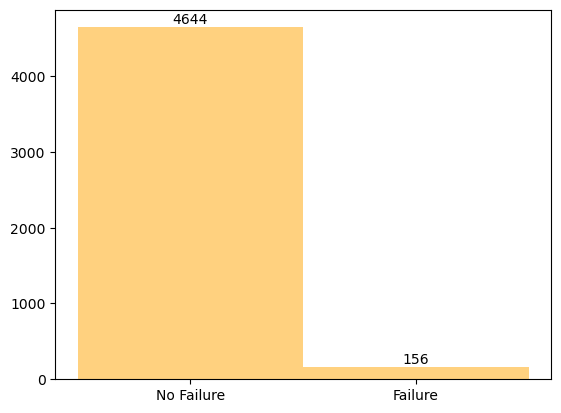

In [3]:
# Visualizzo la distribuzione di failure
n, bins, patches = plt.hist(df_train["Failure"].astype(int), bins=2, color='orange', alpha=0.5, align='mid')
for i in range(len(patches)):
    plt.text(patches[i].get_x() + patches[i].get_width()/2., patches[i].get_height()+5, int(n[i]), ha='center', va='bottom')
plt.xticks([0.25, 0.75], ['No Failure', 'Failure'])

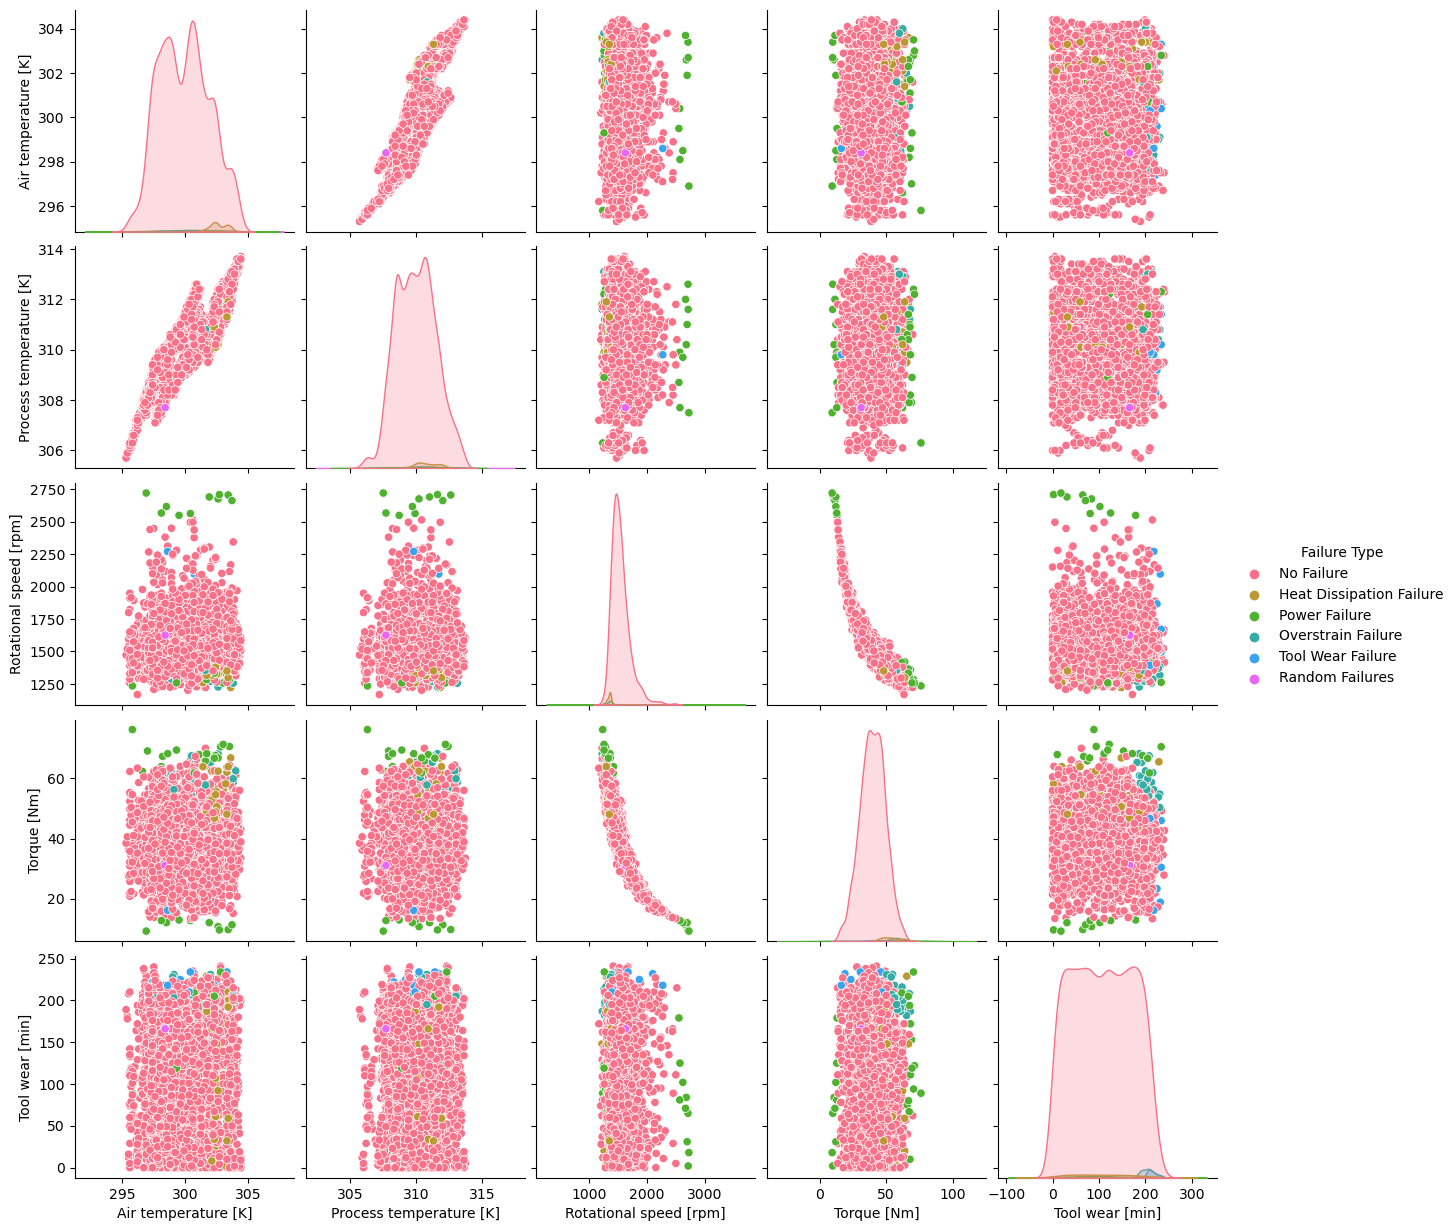

In [4]:
sns.pairplot(df_train, hue='Failure Type', palette='husl', vars =["Air temperature [K]","Process temperature [K]","Rotational speed [rpm]","Torque [Nm]","Tool wear [min]"])

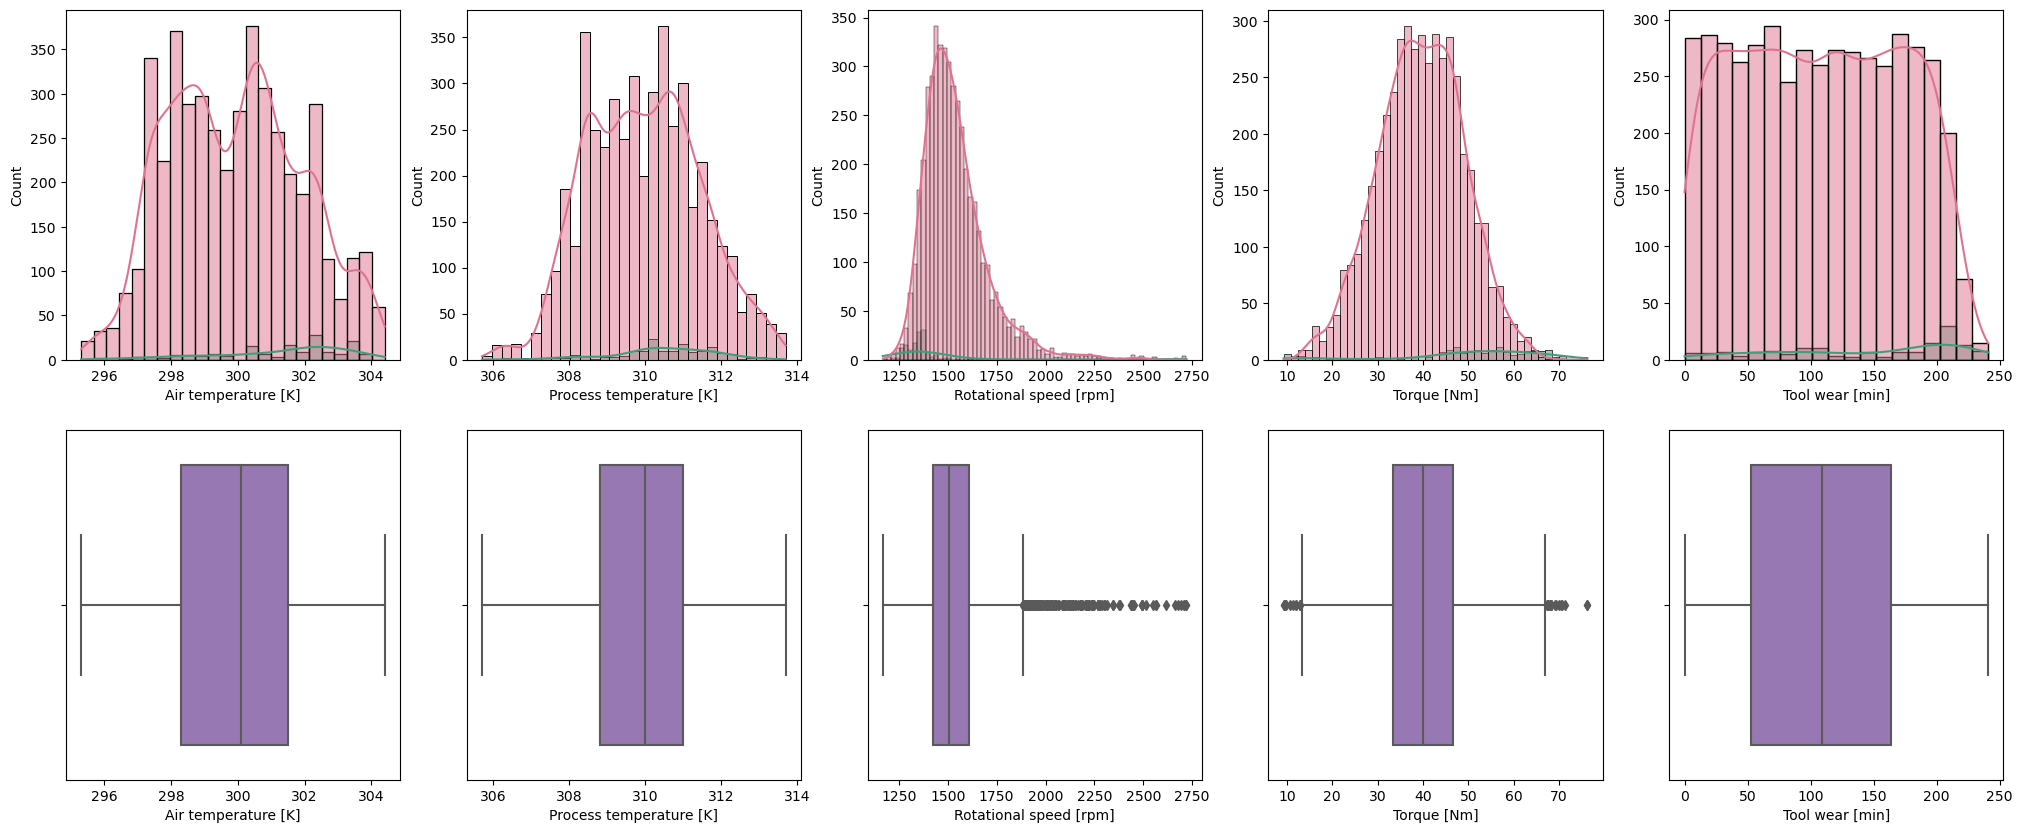

In [5]:
#controllo con boxplot se sono presenti outliers 
fig, axes = plt.subplots(2, 5, figsize=[25,10])
j = 0
colors = ['#E1728F', '#409E7D']

for i in ['Air temperature [K]', 'Process temperature [K]', 'Rotational speed [rpm]', 'Torque [Nm]', 'Tool wear [min]']:
    sns.histplot(data=df_train, x=i, kde=True, ax=axes[0,j], hue='Failure', palette=colors, legend = False)
    sns.boxplot(data=df_train, x=i, ax=axes[1,j], palette=['#976EBD'])
    j+=1

Dai boxplot si vede che rotational speed e torque presentano outliers, provo a scalarli usando robust scaler che viene influenzato meno dalla loro presenza

In [6]:
df_train_scaled = db_scaler(df_train)
df_test_scaled = db_scaler(df_test)

pd.set_option('display.float_format', lambda x: '%.3f' % x)
df_train.describe()

,Type,Air temperature [K],Process temperature [K],Rotational speed [rpm],Torque [Nm],Tool wear [min]
count,4800.000,4800.000,4800.000,4800.000,4800.000,4800.000
mean,0.516,299.980,309.977,1536.170,40.021,108.738
std,0.677,1.991,1.476,175.244,9.875,63.900
min,0.000,295.300,305.700,1168.000,9.300,0.000
25%,0.000,298.300,308.800,1423.000,33.300,53.000
50%,0.000,300.100,310.000,1504.000,40.100,109.000
75%,1.000,301.500,311.000,1608.000,46.700,164.000
max,2.000,304.400,313.700,2721.000,76.200,241.000


In [4]:
df_train.corr()

C:\Users\alexp\AppData\Local\Temp\ipykernel_20364\299540020.py:1: FutureWarning: The default value of numeric_only in DataFrame.corr is deprecated. In a future version, it will default to False. Select only valid columns or specify the value of numeric_only to silence this warning.
  df_train.corr()


,Type,Air temperature [K],Process temperature [K],Rotational speed [rpm],Torque [Nm],Tool wear [min],Failure
Type,1.000000,-0.009617,0.002410,-0.005525,-0.007843,-0.017820,-0.030496
Air temperature [K],-0.009617,1.000000,0.872474,0.009529,0.006060,0.006499,0.123054
Process temperature [K],0.002410,0.872474,1.000000,0.003436,0.003423,0.009482,0.061754
Rotational speed [rpm],-0.005525,0.009529,0.003436,1.000000,-0.878012,0.005975,-0.068019
Torque [Nm],-0.007843,0.006060,0.003423,-0.878012,1.000000,-0.002016,0.206838
Tool wear [min],-0.017820,0.006499,0.009482,0.005975,-0.002016,1.000000,0.096554
Failure,-0.030496,0.123054,0.061754,-0.068019,0.206838,0.096554,1.000000


### Classificazione
#### 1. Random Forest

In [18]:
def db_randomforest(x_db_train,y_db_train,x_db_test) :
    clf = RandomForestClassifier(n_estimators=250, criterion='gini', random_state=20, class_weight={0:1,1:1.7})
    clf.fit(x_db_train,y_db_train)
    y_db_pred_randomforest = clf.predict(x_db_test)
    return y_db_pred_randomforest

print("#### RISULTATI RANDOM FOREST SENZA SCALING SENZA SMOTE ####")
x_train, y_train = xy_splitter(df_train)
x_test, y_test = xy_splitter(df_test)
y_pred = db_randomforest(x_train,y_train,x_test)
print(classification_report(y_test,y_pred))

print("#### RISULTATI RANDOM FOREST CON SCALING SENZA SMOTE ####")
x_train, y_train = xy_splitter(db_scaler(df_train))
x_test, y_test = xy_splitter(db_scaler(df_test))
y_pred = db_randomforest(x_train,y_train,x_test)
print(classification_report(y_test,y_pred))

print("#### RISULTATI RANDOM FOREST SENZA SCALING CON SMOTE ####")
x_train, y_train = xy_splitter(df_train)
x_train, y_train = db_smote(x_train,y_train,0.12)
x_test, y_test = xy_splitter(df_test)
y_pred = db_randomforest(x_train,y_train,x_test)
print(classification_report(y_test,y_pred))

print("#### RISULTATI RANDOM FOREST CON SCALING CON SMOTE ####")
x_train, y_train = xy_splitter(db_scaler(df_train))
x_train, y_train = db_smote(x_train,y_train,0.12)
x_test, y_test = xy_splitter(db_scaler(df_test))
y_pred = db_randomforest(x_train,y_train,x_test)
print(classification_report(y_test,y_pred))


#### RISULTATI RANDOM FOREST SENZA SCALING SENZA SMOTE ####
              precision    recall  f1-score   support

           0       0.98      1.00      0.99       712
           1       1.00      0.42      0.59        31

    accuracy                           0.98       743
   macro avg       0.99      0.71      0.79       743
weighted avg       0.98      0.98      0.97       743

#### RISULTATI RANDOM FOREST CON SCALING SENZA SMOTE ####
              precision    recall  f1-score   support

           0       0.98      1.00      0.99       712
           1       0.93      0.42      0.58        31

    accuracy                           0.97       743
   macro avg       0.95      0.71      0.78       743
weighted avg       0.97      0.97      0.97       743

#### RISULTATI RANDOM FOREST SENZA SCALING CON SMOTE ####
              precision    recall  f1-score   support

           0       0.98      0.99      0.99       712
           1       0.83      0.65      0.73        31

    ac

Visualizzo l'albero decisionale ottenuto dalla migliore iterazione di random forest

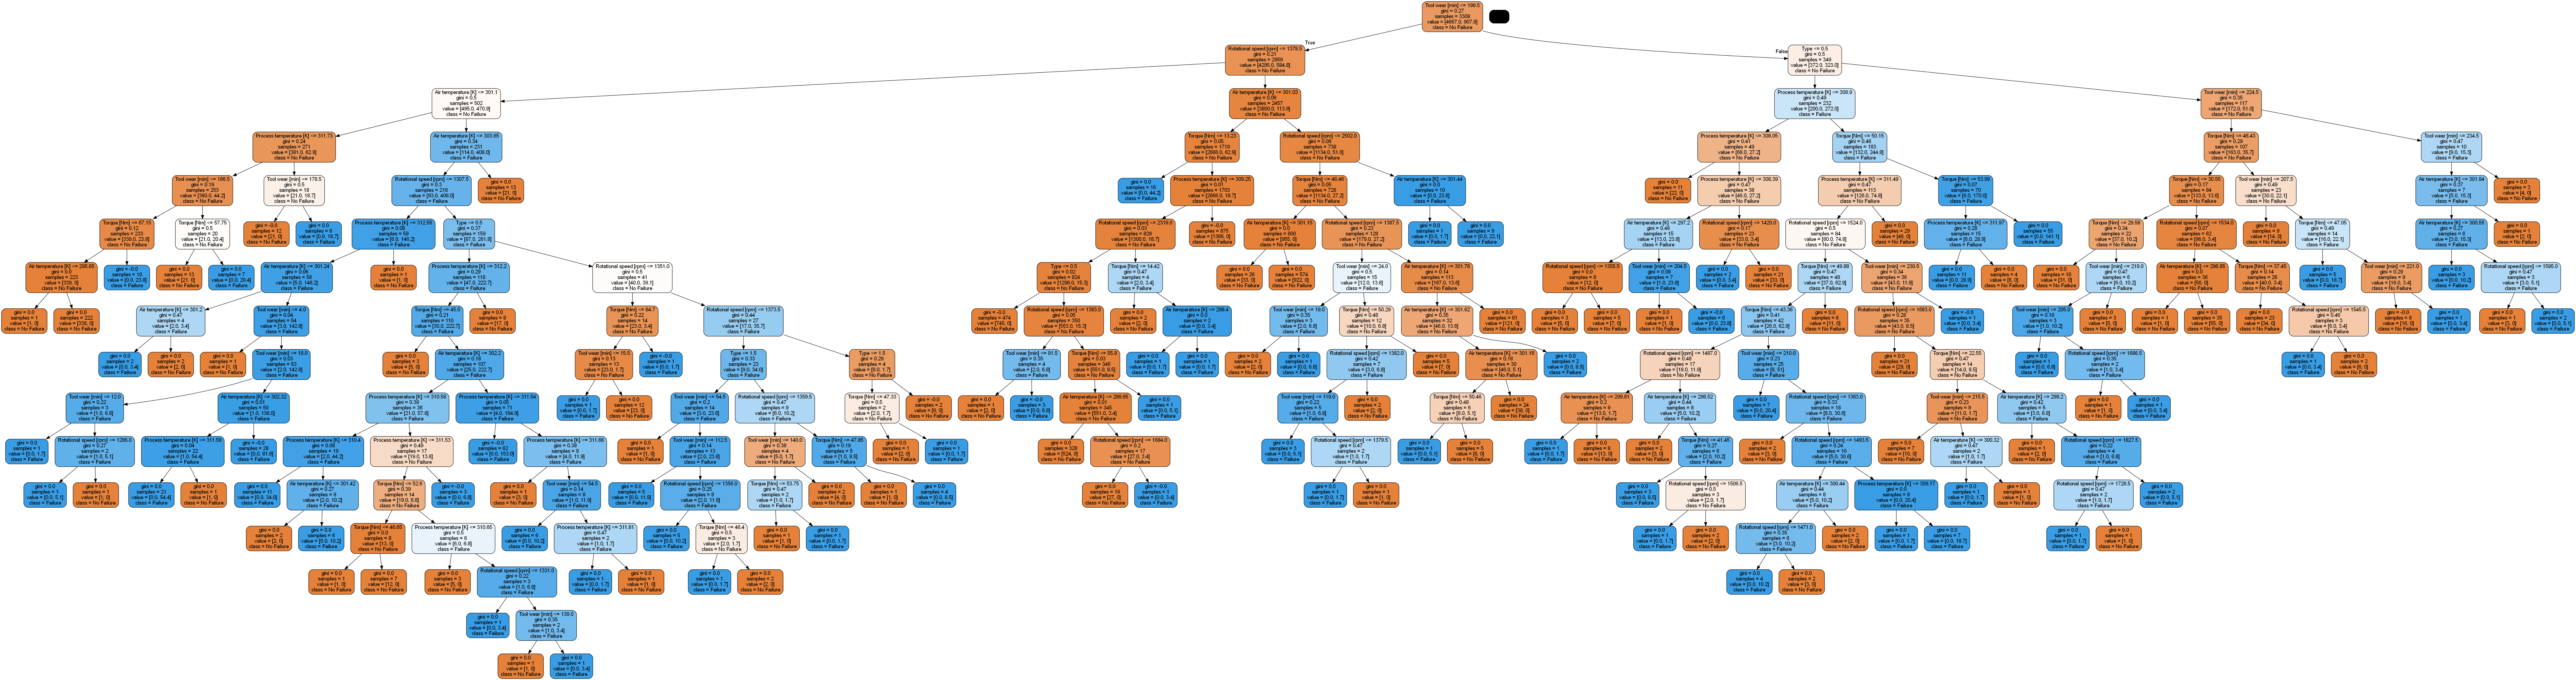

In [19]:
import pydot

x_train, y_train = xy_splitter(df_train)
x_train, y_train = db_smote(x_train,y_train,0.12)
x_test, y_test = xy_splitter(df_test)
clf = RandomForestClassifier(n_estimators=250, criterion='gini', random_state=20, class_weight={0:1,1:1.7})
clf.fit(x_train,y_train)


estimator = clf.estimators_[5]
export_graphviz(estimator, out_file = 'ros_tree.dot', rounded = True, proportion = False, precision = 2, filled = True, leaves_parallel= False,feature_names = x_train.columns.values, class_names=['No Failure','Failure'])

(graph,) = pydot.graph_from_dot_file('ros_tree.dot')
graph.write_png('tree.png')

from IPython.display import Image
Image(filename = 'tree.png')

#### 2 SVM

In [21]:
# Definisci i parametri da esplorare nella ricerca della griglia
parameters = {
    'C': [10000,100000],  #1,                    #per binarie sbilanciate utilizzare valori piccoli
    'kernel': ['rbf'], #'sigmoid', 'poly'  #solitamente rbf, sigmoid o polynomial in binarie sbilanciate
    'gamma': ['scale','auto'],
    'class_weight': [{0: 1, 1: w} for w in [1, 1.5, 2, 2.5]]
}

#Funzione che
def db_svm(x_db_train,y_db_train,x_db_test,scorer) :
    _svc = svm.SVC()
    _scoring = make_scorer(scorer, pos_label=1)
    grid_search_svc = GridSearchCV(_svc, parameters, scoring=_scoring, cv=5)
    grid_search_svc.fit(x_db_train,y_db_train)
    print("Migliori parametri per ",scorer.__name__ , " : ",grid_search_svc.best_params_)
    y_db_pred = grid_search_svc.predict(x_db_test)
    return y_db_pred

print("#### RISULTATI SVM SENZA SCALING SENZA SMOTE ####")
x_train, y_train = xy_splitter(df_train)
x_test, y_test = xy_splitter(df_test)
y_pred = db_svm(x_train,y_train,x_test,f1_score)
print(classification_report(y_test,y_pred))

print("#### RISULTATI SVM CON SCALING SENZA SMOTE ####")
x_train, y_train = xy_splitter(db_scaler(df_train))
x_test, y_test = xy_splitter(db_scaler(df_test))
y_pred = db_svm(x_train,y_train,x_test,f1_score)
print(classification_report(y_test,y_pred))

print("#### RISULTATI SVM SENZA SCALING CON SMOTE ####")
x_train, y_train = xy_splitter(df_train)
x_train, y_train = db_smote(x_train,y_train,0.10)
x_test, y_test = xy_splitter(df_test)
y_pred = db_svm(x_train,y_train,x_test,f1_score)
print(classification_report(y_test,y_pred))

print("#### RISULTATI SVM CON SCALING CON SMOTE ####")
x_train, y_train = xy_splitter(db_scaler(df_train))
x_train, y_train = db_smote(x_train,y_train,0.10)
x_test, y_test = xy_splitter(db_scaler(df_test))
y_pred = db_svm(x_train,y_train,x_test,f1_score)
print(classification_report(y_test,y_pred))

#### RISULTATI SVM SENZA SCALING SENZA SMOTE ####
Migliori parametri per  f1_score  :  {'C': 100000, 'class_weight': {0: 1, 1: 2.5}, 'gamma': 'scale', 'kernel': 'rbf'}
              precision    recall  f1-score   support

           0       0.98      0.99      0.98       712
           1       0.62      0.42      0.50        31

    accuracy                           0.97       743
   macro avg       0.80      0.70      0.74       743
weighted avg       0.96      0.97      0.96       743

#### RISULTATI SVM CON SCALING SENZA SMOTE ####
Migliori parametri per  f1_score  :  {'C': 10000, 'class_weight': {0: 1, 1: 2}, 'gamma': 'auto', 'kernel': 'rbf'}
              precision    recall  f1-score   support

           0       0.99      0.99      0.99       712
           1       0.72      0.68      0.70        31

    accuracy                           0.98       743
   macro avg       0.86      0.83      0.84       743
weighted avg       0.98      0.98      0.98       743

#### RISULTATI S

#### 3. LOGISTIC REGRESSION

In [23]:
# Definisci i parametri da esplorare nella ricerca della griglia
parameters = {
    'C': [1,5,10], # 1, 0.01
    'solver': ['liblinear', 'lbfgs'],
    'class_weight': [{0: 1, 1: w} for w in [1, 1.5, 2, 2.5]]
}


def db_logr(x_db_train,y_db_train,x_db_test,scorer) :
    logit = LogisticRegression()
    _scoring = make_scorer(scorer, pos_label=1)
    grid_search_logr = GridSearchCV(logit, parameters, scoring=_scoring, cv=5)
    grid_search_logr.fit(x_db_train,y_db_train)
    print("Migliori parametri per ",scorer.__name__ , " : ",grid_search_logr.best_params_)
    y_db_pred = grid_search_logr.predict(x_db_test)
    return y_db_pred

print("#### RISULTATI LOGISTIC REGRESSION SENZA SCALING SENZA SMOTE ####")
x_train, y_train = xy_splitter(df_train)
x_test, y_test = xy_splitter(df_test)
y_pred = db_logr(x_train,y_train,x_test,f1_score)
print(classification_report(y_test,y_pred))

print("#### RISULTATI LOGISTIC REGRESSION CON SCALING SENZA SMOTE ####")
x_train, y_train = xy_splitter(db_scaler(df_train))
x_test, y_test = xy_splitter(db_scaler(df_test))
y_pred = db_logr(x_train,y_train,x_test,f1_score)
print(classification_report(y_test,y_pred))

print("#### RISULTATI LOGISTIC REGRESSION SENZA SCALING CON SMOTE ####")
x_train, y_train = xy_splitter(df_train)
x_train, y_train = db_smote(x_train,y_train,0.1)
x_test, y_test = xy_splitter(df_test)
y_pred = db_logr(x_train,y_train,x_test,f1_score)
print(classification_report(y_test,y_pred))

print("#### RISULTATI LOGISTIC REGRESSION CON SCALING CON SMOTE ####")
x_train, y_train = xy_splitter(db_scaler(df_train))
x_train, y_train = db_smote(x_train,y_train,0.1)
x_test, y_test = xy_splitter(db_scaler(df_test))
y_pred = db_logr(x_train,y_train,x_test,f1_score)
print(classification_report(y_test,y_pred))

#### RISULTATI LOGISTIC REGRESSION SENZA SCALING SENZA SMOTE ####
Migliori parametri per  f1_score  :  {'C': 1, 'class_weight': {0: 1, 1: 2}, 'solver': 'liblinear'}
              precision    recall  f1-score   support

           0       0.97      1.00      0.98       712
           1       0.80      0.26      0.39        31

    accuracy                           0.97       743
   macro avg       0.88      0.63      0.69       743
weighted avg       0.96      0.97      0.96       743

#### RISULTATI LOGISTIC REGRESSION CON SCALING SENZA SMOTE ####
Migliori parametri per  f1_score  :  {'C': 10, 'class_weight': {0: 1, 1: 2.5}, 'solver': 'liblinear'}
              precision    recall  f1-score   support

           0       0.97      0.99      0.98       712
           1       0.62      0.26      0.36        31

    accuracy                           0.96       743
   macro avg       0.79      0.63      0.67       743
weighted avg       0.95      0.96      0.95       743

#### RISULTATI 

c:\Users\alexp\anaconda3\envs\myenv\lib\site-packages\sklearn\linear_model\_logistic.py:458: ConvergenceWarning: lbfgs failed to converge (status=1):
STOP: TOTAL NO. of ITERATIONS REACHED LIMIT.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
Please also refer to the documentation for alternative solver options:
    https://scikit-learn.org/stable/modules/linear_model.html#logistic-regression
  n_iter_i = _check_optimize_result(
c:\Users\alexp\anaconda3\envs\myenv\lib\site-packages\sklearn\linear_model\_logistic.py:458: ConvergenceWarning: lbfgs failed to converge (status=1):
STOP: TOTAL NO. of ITERATIONS REACHED LIMIT.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
Please also refer to the documentation for alternative solver options:
    https://scikit-learn.org/stable/modules/linear_model.html#logisti

Migliori parametri per  f1_score  :  {'C': 5, 'class_weight': {0: 1, 1: 1.5}, 'solver': 'liblinear'}
              precision    recall  f1-score   support

           0       0.98      0.98      0.98       712
           1       0.58      0.48      0.53        31

    accuracy                           0.96       743
   macro avg       0.78      0.73      0.75       743
weighted avg       0.96      0.96      0.96       743

#### RISULTATI LOGISTIC REGRESSION CON SCALING CON SMOTE ####
Migliori parametri per  f1_score  :  {'C': 1, 'class_weight': {0: 1, 1: 2.5}, 'solver': 'liblinear'}
              precision    recall  f1-score   support

           0       0.98      0.96      0.97       712
           1       0.34      0.48      0.40        31

    accuracy                           0.94       743
   macro avg       0.66      0.72      0.68       743
weighted avg       0.95      0.94      0.94       743



#### 4. NEURAL NETWORK

In [ ]:
import keras
from keras.callbacks import Callback,ModelCheckpoint
from keras.models import Sequential,load_model
from keras.layers import Dense, Dropout
from keras.wrappers.scikit_learn import KerasClassifier
import keras.backend as K

x_train, y_train = xy_splitter(df_train)
x_test, y_test = xy_splitter(df_test)

x_train, x_val, y_train, y_val = train_test_split(x_train, y_train, test_size=0.3, stratify = y_train, random_state=3)

weight_for_0 = 1
weight_for_1 = 1.8

model = keras.Sequential(
    [
        keras.layers.Dense(
            256, activation="relu", input_shape=(x_train.shape[-1],)
        ),
        keras.layers.Dense(256, activation="relu"),
        keras.layers.Dropout(0.3),
        keras.layers.Dense(256, activation="relu"),
        keras.layers.Dropout(0.3),
        keras.layers.Dense(1, activation="sigmoid"),
    ]
)

model.compile(
    optimizer=keras.optimizers.Adam(1e-4), loss="binary_crossentropy",
)

class_weight = {0: weight_for_0, 1: weight_for_1}

model.fit(
    x_train,
    y_train,
    batch_size=1000,
    epochs=3000,
    verbose=0,
    validation_data=(x_val, y_val),
    class_weight=class_weight,
)


results = model.evaluate(x_test, y_test)

lello = model.predict(x_test)
y_pred = (np.rint(model.predict(x_test))).astype(int)
print("#### RISULTATI RETE SENZA SCALING SENZA SMOTE ####")
print(classification_report(y_test,y_pred))

24/24 [==============================] - 0s 957us/step
#### RISULTATI RETE SENZA SCALING SENZA SMOTE ####
              precision    recall  f1-score   support

           0       0.97      1.00      0.98       712
           1       0.83      0.32      0.47        31

    accuracy                           0.97       743
   macro avg       0.90      0.66      0.72       743
weighted avg       0.97      0.97      0.96       743



In [ ]:
x_train, y_train = xy_splitter(db_scaler(df_train))
x_test, y_test = xy_splitter(db_scaler(df_test))

x_train, x_val, y_train, y_val = train_test_split(x_train, y_train, test_size=0.3, stratify = y_train, random_state=3)

counts = np.bincount(y_train.values)
weight_for_0 = 1
weight_for_1 = 1.8

model = keras.Sequential(
    [
        keras.layers.Dense(
            256, activation="relu", input_shape=(x_train.shape[-1],)
        ),
        keras.layers.Dense(256, activation="relu"),
        keras.layers.Dropout(0.3),
        keras.layers.Dense(256, activation="relu"),
        keras.layers.Dropout(0.3),
        keras.layers.Dense(1, activation="sigmoid"),
    ]
)

metrics = [

    keras.metrics.Precision(name="precision"),
    keras.metrics.Recall(name="recall"),
]

model.compile(
    optimizer=keras.optimizers.Adam(1e-4), loss="binary_crossentropy",
)

class_weight = {0: weight_for_0, 1: weight_for_1}

model.fit(
    x_train,
    y_train,
    batch_size=1200,
    epochs=3000,
    verbose=0,
    validation_data=(x_val, y_val),
    class_weight=class_weight,
)


results = model.evaluate(x_test, y_test)

lello = model.predict(x_test)
y_pred = (np.rint(model.predict(x_test))).astype(int)

print("#### RISULTATI RETE CON SCALING SENZA SMOTE ####")
print(classification_report(y_test,y_pred))

24/24 [==============================] - 0s 957us/step
#### RISULTATI RETE CON SCALING SENZA SMOTE ####
              precision    recall  f1-score   support

           0       0.98      0.99      0.98       712
           1       0.68      0.48      0.57        31

    accuracy                           0.97       743
   macro avg       0.83      0.74      0.77       743
weighted avg       0.97      0.97      0.97       743



In [ ]:
x_train, y_train = xy_splitter(df_train)
x_train, y_train = db_smote(x_train,y_train,0.1)
x_test, y_test = xy_splitter(df_test)

x_train, x_val, y_train, y_val = train_test_split(x_train, y_train, test_size=0.3, stratify = y_train, random_state=3)

counts = np.bincount(y_train.values)
weight_for_0 = 1
weight_for_1 = 1.8

model = keras.Sequential(
    [
        keras.layers.Dense(
            256, activation="relu", input_shape=(x_train.shape[-1],)
        ),
        keras.layers.Dense(256, activation="relu"),
        keras.layers.Dropout(0.3),
        keras.layers.Dense(256, activation="relu"),
        keras.layers.Dropout(0.3),
        keras.layers.Dense(1, activation="sigmoid"),
    ]
)

metrics = [

    keras.metrics.Precision(name="precision"),
    keras.metrics.Recall(name="recall"),
]

model.compile(
    optimizer=keras.optimizers.Adam(1e-4), loss="binary_crossentropy",
)

class_weight = {0: weight_for_0, 1: weight_for_1}

model.fit(
    x_train,
    y_train,
    batch_size=1000,
    epochs=3000,
    verbose=0,
    validation_data=(x_val, y_val),
    class_weight=class_weight,
)


results = model.evaluate(x_test, y_test)

lello = model.predict(x_test)
y_pred = (np.rint(model.predict(x_test))).astype(int)

print("#### RISULTATI RETE SENZA SCALING CON SMOTE ####")
print(classification_report(y_test,y_pred))

24/24 [==============================] - 0s 1ms/step
#### RISULTATI RANDOM FOREST SENZA SCALING CON SMOTE ####
              precision    recall  f1-score   support

           0       0.98      0.99      0.98       712
           1       0.61      0.45      0.52        31

    accuracy                           0.97       743
   macro avg       0.79      0.72      0.75       743
weighted avg       0.96      0.97      0.96       743



In [ ]:
x_train, y_train = xy_splitter(db_scaler(df_train))
x_train, y_train = db_smote(x_train,y_train,0.1)
x_test, y_test = xy_splitter(db_scaler(df_test))

x_train, x_val, y_train, y_val = train_test_split(x_train, y_train, test_size=0.3, stratify = y_train, random_state=3)

counts = np.bincount(y_train.values)
weight_for_0 = 1
weight_for_1 = 1.8

model = keras.Sequential(
    [
        keras.layers.Dense(
            256, activation="relu", input_shape=(x_train.shape[-1],)
        ),
        keras.layers.Dense(256, activation="relu"),
        keras.layers.Dropout(0.3),
        keras.layers.Dense(256, activation="relu"),
        keras.layers.Dropout(0.3),
        keras.layers.Dense(1, activation="sigmoid"),
    ]
)

metrics = [

    keras.metrics.Precision(name="precision"),
    keras.metrics.Recall(name="recall"),
]

model.compile(
    optimizer=keras.optimizers.Adam(1e-4), loss="binary_crossentropy",
)

class_weight = {0: weight_for_0, 1: weight_for_1}

model.fit(
    x_train,
    y_train,
    batch_size=1200,
    epochs=4000,
    verbose=0,
    validation_data=(x_val, y_val),
    class_weight=class_weight,
)


results = model.evaluate(x_test, y_test)

lello = model.predict(x_test)
y_pred = (np.rint(model.predict(x_test))).astype(int)

print("#### RISULTATI RETE CON SCALING CON SMOTE ####")
print(classification_report(y_test,y_pred))

24/24 [==============================] - 0s 870us/step
#### RISULTATI RETE CON SCALING CON SMOTE ####
              precision    recall  f1-score   support

           0       0.98      0.99      0.98       712
           1       0.62      0.52      0.56        31

    accuracy                           0.97       743
   macro avg       0.80      0.75      0.77       743
weighted avg       0.96      0.97      0.96       743

